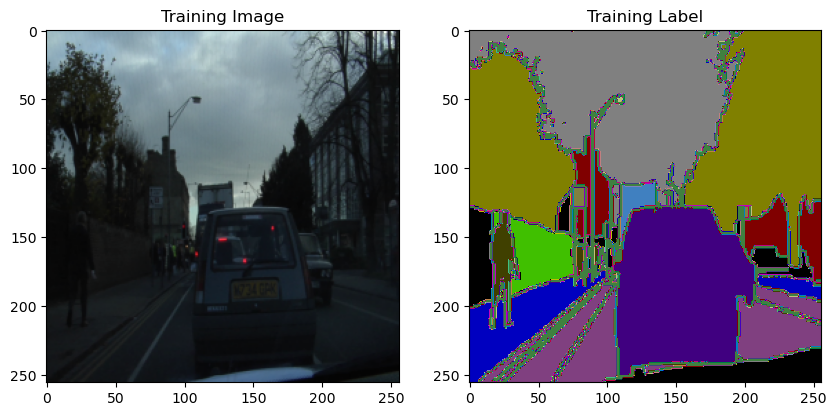

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
from skimage.transform import resize
from matplotlib.colors import ListedColormap

# Load all the labels and their corresponding colors from a CSV file
class_dict_path = os.path.expanduser('CamVid/class_dict.csv')
class_dict = pd.read_csv(class_dict_path)

# Convert class colors to a dictionary for easy lookup
color_mapping = {class_name: [r, g, b] for class_name, r, g, b in zip(class_dict['name'], class_dict['r'], class_dict['g'], class_dict['b'])}

def load_image(path):
    """Load an image from a file path."""
    return imread(path)

def resize_image(image, target_size=(256, 256)):
    """Resize an image to the target size."""
    return resize(image, target_size, preserve_range=True, mode='reflect', anti_aliasing=True)

def image_to_label(image, color_mapping, tolerance: int=0):
    """
    Convert an RGB labeled image to categorical labels based on specified color mapping.
    A tolerance for color matching can be specified to handle minor variations.
    """
    label = np.zeros(image.shape[:2], dtype=np.int32)
    for class_idx, color in enumerate(color_mapping.values()):
        # Create a mask where the pixel matches the color within the given tolerance
        class_mask = np.all(np.abs(image - np.array(color, dtype=int)) <= tolerance, axis=-1)
        label[class_mask] = class_idx
    return label


def load_dataset(image_dir, label_dir, color_mapping):
    """Load and preprocess the dataset from specified directories, ensuring images match their labels."""
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])

    # Adjust label_paths to match image_paths based on the naming convention
    adjusted_label_paths = []
    for image_path in image_paths:
        base_name = os.path.basename(image_path)
        label_base_name = base_name.replace('.png', '_L.png')  # Adjust to match the label naming convention
        label_path = os.path.join(label_dir, label_base_name)
        adjusted_label_paths.append(label_path)
    
    # Load and resize images and labels
    images = np.stack([resize_image(load_image(path)) for path in image_paths])
    labels = np.stack([image_to_label(resize_image(load_image(path), target_size=images[0].shape[:2]), color_mapping, 1) for path in adjusted_label_paths])
    
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, num_classes=len(color_mapping))
    
    return images, labels

# Folders containing the training, validation, and test datasets
train_dir = os.path.expanduser('CamVid/train')
train_labels_dir = os.path.expanduser('CamVid/train_labels')
validation_dir = os.path.expanduser('CamVid/val')
validation_labels_dir = os.path.expanduser('CamVid/val_labels')
test_dir = os.path.expanduser('CamVid/test')
test_labels_dir = os.path.expanduser('CamVid/test_labels')

# Load datasets
X_train, Y_train = load_dataset(train_dir, train_labels_dir, color_mapping)
X_val, Y_val = load_dataset(validation_dir, validation_labels_dir, color_mapping)
X_test, Y_test = load_dataset(test_dir, test_labels_dir, color_mapping)

# Create a custom colormap from the color mapping
custom_colors = np.array(list(color_mapping.values())) / 255.0
custom_cmap = ListedColormap(custom_colors)

# Plot a sample training image and its corresponding label with the custom colormap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0].astype(np.uint8))
plt.title('Training Image')

plt.subplot(1, 2, 2)
plt.imshow(np.argmax(Y_train[0], axis=-1), cmap=custom_cmap)
plt.title('Training Label')

plt.show()

In [4]:
# Import necessary layers from TensorFlow Keras for building the U-Net model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def conv_block(input_tensor, num_filters):
    """
    Create a convolutional block with two Conv2D layers.
    Each layer uses ReLU activation and 'same' padding to keep dimensions unchanged.
    
    Parameters:
    - input_tensor: The input tensor for the convolutional block.
    - num_filters: The number of filters for the Conv2D layers.
    
    Returns:
    - The output tensor of the convolutional block.
    """
    tensor = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    tensor = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(tensor)
    return tensor

def unet(input_size, num_classes, base_num_filters=64):
    """
    Build a U-Net model for semantic segmentation.
    
    Parameters:
    - input_size: The shape of the input images.
    - num_classes: The number of classes for segmentation.
    
    Returns:
    - The U-Net model.
    """
    # Input layer of the model
    inputs = Input(input_size)
    
    # Downsampling path
    conv1 = conv_block(inputs, base_num_filters)  # First convolutional block
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # First pooling to reduce dimensions
    
    conv2 = conv_block(pool1, base_num_filters * 2)  # Second convolutional block
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # Second pooling to further reduce dimensions
    
    # Bottleneck
    conv3 = conv_block(pool2, base_num_filters * 4)
    
    # Upsampling path
    up1 = UpSampling2D(size=(2, 2))(conv3)  # First upsampling to increase dimensions
    merge1 = concatenate([conv2, up1], axis=3)  # Concatenate the feature map from downsampling path
    conv4 = conv_block(merge1, base_num_filters * 2)  # Fourth convolutional block
    
    up2 = UpSampling2D(size=(2, 2))(conv4)  # Second upsampling to further increase dimensions
    merge2 = concatenate([conv1, up2], axis=3)  # Concatenate the feature map from the initial downsampling path
    conv5 = conv_block(merge2, base_num_filters)  # Final convolutional block before the output layer
    
    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv5) # Conv2D layer to predict class for each pixel
    
    # Construct and return the U-Net model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model

# Define the model
input_size = X_train[0].shape  # Assuming X_train is your input image batch
model = unet(input_size, num_classes=len(color_mapping))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    X_train, Y_train, 
    batch_size=16, 
    epochs=50, 
    validation_data=(X_val, Y_val)
)

(0.0, 2.0)

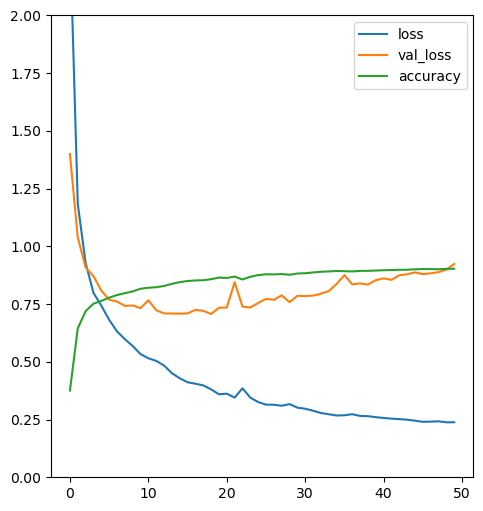

In [17]:
# evaluation = model.evaluate(X_test, Y_test)
# print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")
# figure of two side-by-side plots showing the training loss and accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
# set y axis range from 0 to 1
plt.ylim((0,2))

1/1 [==============================] - 0s 357ms/step


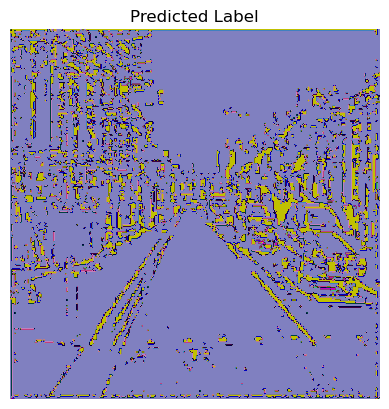

In [7]:
def predict_label(model, image):
    image_preprocessed = resize_image(load_image(image), target_size=input_size)
    image_preprocessed = np.expand_dims(image_preprocessed, axis=0)  # Add batch dimension
    prediction = model.predict(image_preprocessed)
    predicted_label = np.argmax(prediction, axis=-1)[0]  # Remove batch dimension
    return predicted_label

# Load and preprocess an unseen image
unseen_image_path = 'CamVid/test/Seq05VD_f05040.png'
predicted_label = predict_label(model, unseen_image_path)

# Display the prediction
plt.imshow(predicted_label, cmap=custom_cmap)
plt.title('Predicted Label')
plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch

class UNetHyperModel(HyperModel):
    def __init__(self, input_size, num_classes):
        self.input_size = input_size
        self.num_classes = num_classes

    def build(self, hp):
        # Use hp.Int('name', min_value, max_value, step) to define the range of hyperparameters
        num_filters = hp.Int('num_filters', 32, 256, step=32)
        model = unet(self.input_size, self.num_classes, num_filters)
        # You can also tune the learning rate and other hyperparameters in a similar way
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

# Instantiate the tuner
tuner = RandomSearch(
    UNetHyperModel(input_size, num_classes=len(color_mapping)),
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials
    executions_per_trial=1,
    directory='/tmp/tuner',
    project_name='unet_tuning'
)

# Perform hyperparameter tuning
tuner.search(X_train, Y_train, epochs=20, validation_split=0.2)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |num_filters
8.1397e-05        |8.1397e-05        |learning_rate

Epoch 1/20
